# Tutorial for Replacement

Replacing substituents on the 3D structure of a molecule is a very common requirement. For small numbers of substitutions, manual modifications can be made using visualization tools such as GaussView. An automated tool becomes necessary when faced with large-scale dataset expansion.

RDKit provides functions for substituent replacement, which perform well on 2D molecular maps but are difficult to maintain robustness on 3D structural substitutions. A set of automatic replacement functions for single-bond linked substituents has been implemented in MolOP, allowing to keep the molecular backbone and the substituents conformationally invariant to each other and to find a suitable angle of rotation making the site resistance small.


## Demo Data

A C-H activation reaction of a ferrocene derivative catalyzed by an amino acid amide, where a possible transition state is shown in the figure. Note that the hydrogen atom on number 17 is activated.

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 1123.27it/s]
INFO - 0 files failed to parse, 1 successfully parsed


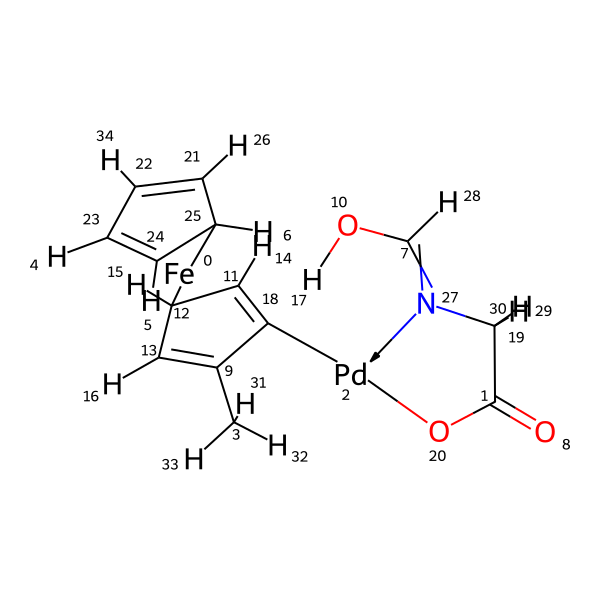

In [1]:
from molop import AutoParser
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 600, 600

template_rp = AutoParser("../../tests/test_files/g16gjf/Template-Rp.gjf")[0][0]
template_rp.rdmol

The activity of this reaction may be affected by the derivatization of ferrocene itself and the derivatization of amino acid amide. Therefore, we hope to modify this template to produce the corresponding transition state in batches.

In [2]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

demo_data = pd.read_csv("../data/replacement_demo_data.csv", index_col=0)
print(demo_data.to_markdown())

|    | Catalyst                               | Reactant                                                          |
|---:|:---------------------------------------|:------------------------------------------------------------------|
|  0 | CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)C(=O)O | CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28                          |
|  1 | CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)C(=O)O | CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28                          |
|  2 | CC[C@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O | CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28                          |
|  3 | CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)C(=O)O | CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28                          |
|  4 | CC(C)(C)OC(=O)N[C@H](C(=O)O)C(C)(C)C   | CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28                          |
|  5 | CC(=O)N[C@@H](Cc1ccccc1)C(=O)O         | CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28                          |
|  6 | CC(=O)N[C@@H](Cc1ccccc1)C(=O)O         | CN(C)CC12C3C4C5C1[Fe]453

Sometimes we can tell what substituent should be replaced at what position, but more often than not, we only know the structure of the substrate. The demo data does exactly that. We can quickly access the substituents to be replaced with the help of RDKit and known substrate common parts.

In [3]:
from rdkit import Chem
from rdkit.Chem.rdmolops import ReplaceCore


def trasform_substituent(smiles):
    rwmol = Chem.RWMol(Chem.MolFromSmiles(smiles))
    rwmol.RemoveAtom(0)
    rwmol.GetAtomWithIdx(0).SetNumRadicalElectrons(
        rwmol.GetAtomWithIdx(0).GetNumRadicalElectrons() + 1
    )
    return Chem.MolToSmiles(rwmol.GetMol())


def transform_substituents(row: pd.Series):
    smis = row[0].split(".")
    return pd.Series([trasform_substituent(s) for s in smis])


core_fe = Chem.MolFromSmiles("CC12C3C4C5C1[Fe]23451678C2C1C6C7C28")
core_animo = Chem.MolFromSmiles("O=CNCC(=O)O")

fe_substituents = demo_data.apply(
    lambda row: pd.Series(
        Chem.MolToSmiles(
            ReplaceCore(
                Chem.MolFromSmiles(row["Reactant"]),
                core_fe,
            )
        )
    ),
    axis=1,
)

amino_substituents = demo_data.apply(
    lambda row: pd.Series(
        Chem.MolToSmiles(
            ReplaceCore(
                Chem.MolFromSmiles(row["Catalyst"]),
                core_animo,
            )
        )
    ),
    axis=1,
)

In [4]:
fe_substituents_df = fe_substituents.apply(transform_substituents, axis=1).fillna("[H]")
fe_substituents_df.columns = ["fe_substituents_0", "fe_substituents_1"]
amino_substituents_df = amino_substituents.apply(transform_substituents, axis=1).fillna(
    "[H]"
)
amino_substituents_df.columns = ["amino_substituents_0", "amino_substituents_1"]
replacemnet_df = pd.concat([fe_substituents_df, amino_substituents_df], axis=1)

print(replacemnet_df.to_markdown())

|    | fe_substituents_0   | fe_substituents_1       | amino_substituents_0   | amino_substituents_1   |
|---:|:--------------------|:------------------------|:-----------------------|:-----------------------|
|  0 | C[N]C               | [H]                     | CC(C)(C)[O]            | [CH2]c1ccccc1          |
|  1 | C[N]C               | [H]                     | CC(C)(C)[O]            | [CH2]c1ccccc1          |
|  2 | C[N]C               | [H]                     | CC(C)(C)[O]            | C[CH]CC                |
|  3 | C[N]C               | [H]                     | CC(C)(C)[O]            | [CH2]c1ccccc1          |
|  4 | C[N]C               | [H]                     | CC(C)(C)[O]            | C[C](C)C               |
|  5 | C[N]C               | [H]                     | [CH3]                  | [CH2]c1ccccc1          |
|  6 | C[N]C               | [H]                     | [CH3]                  | [CH2]c1ccccc1          |
|  7 | C[N]C               | [H]                     | 

Subsequently, substitutions are made at the specified positions (based on the `bind_idx` parameter) according to the obtained substituents. Note that substituent substitution only guarantees the absolute atom number of the substructure before `bind_idx`; the atom number of the new substituent will come last. Therefore, it is necessary to ensure that positions with a larger `bind_idx` are substituted first.

In [5]:
def preprocess_template_1(row: pd.Series):
    ts_like_rp = (
        template_rp.replace_substituent(
            "[H]", row["fe_substituents_1"], bind_idx=34, angle_split=20
        )
        .replace_substituent(
            "[H]", row["fe_substituents_0"], bind_idx=32, angle_split=20
        )
        .replace_substituent(
            "[H]", row["amino_substituents_1"], bind_idx=29, angle_split=20
        )
        .replace_substituent("[H]", row["amino_substituents_0"], 28, angle_split=20)
    )
    return ts_like_rp.rdmol


replacemnet_rdmols = replacemnet_df.progress_apply(preprocess_template_1, axis=1)

100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


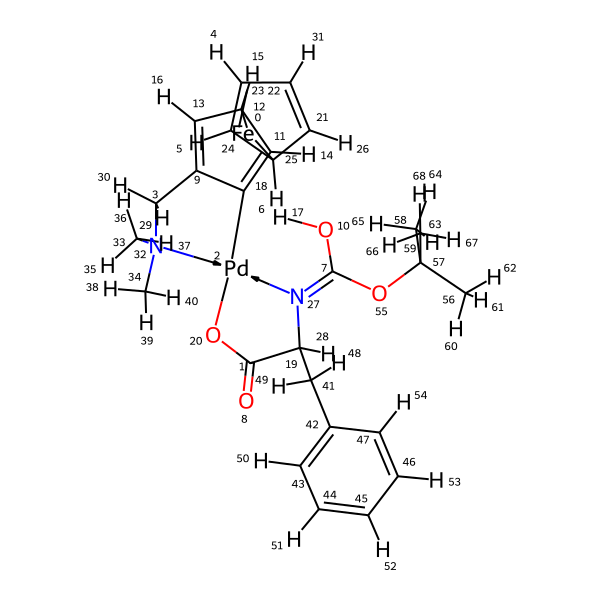

In [6]:
replacemnet_rdmols.iloc[0]

If the representation of the new substituent is based on SMILES, then its conformation is generated by RDKit, which means that its structural accuracy is not higher than the force field level. In addition, RDKit's conformational generation algorithm does not support metals very well, in particular it is difficult to generate the correct coordination conformer. In this scenario, you can just pass the rdmol object and just make sure that there is a free radical in it, or if there is more than one then you can specify it by the relative order within. 

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 1017.79it/s]
INFO - 0 files failed to parse, 1 successfully parsed


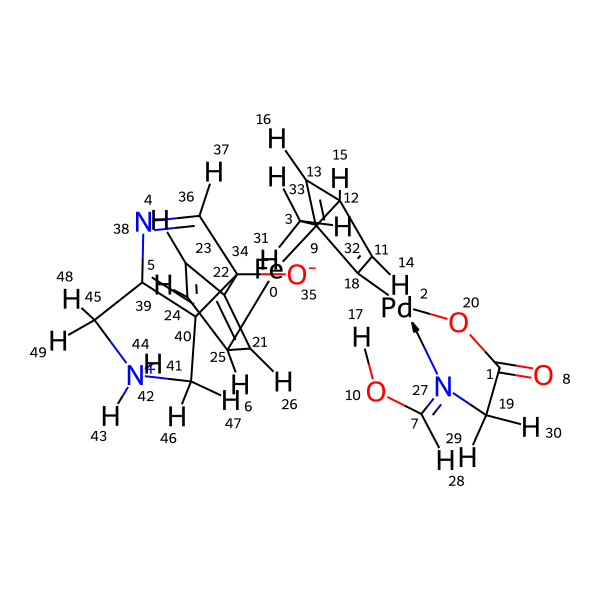

In [7]:
substituent = AutoParser("../../tests/test_files/xyz/dsgdb9nsd_046611-4/12.xyz")[0][
    0
].rdmol

template_rp.replace_substituent("[H]", substituent, bind_idx=34).rdmol